<a href="https://colab.research.google.com/github/stiepan/MLCourse/blob/master/softmax_(5).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Softmax regression

In this exercise you will train a softmax regression model to recognize handwritten digits.
  
The general setup is as follows:
* we are given a set of pairs $(x, y)$, where $x \in R^D$ is a vector of real numbers representing the features, and $y \in \{1,...,c\}$ is the target (in our case we have ten classes, so $c=10$),
* for a given $x$ we model the probability of $y=j$ by $$h(x)_j=p_j = \frac{e^{w_j^Tx}}{\sum_{i=1}^c e^{w_i^Tx}},$$
* to find the right $w$ we will optimize the so called multiclass log loss:
$$L(y,p) = \log{p_y},$$
$$J(w) = -\frac{1}{n}\sum_{i=1}^n L(y_i,h(x)),$$
* with the loss function in hand we can improve our guesses iteratively:
    * $w_{ij}^{t+1} = w_{ij}^t - \text{step_size} \cdot \frac{\partial J(w)}{\partial w_{ij}}$,
* we can end the process after some predefined number of epochs (or when the changes are no longer meaningful).

Let's start with importing the MNIST dataset.

In [1]:
!wget -O mnist.npz https://s3.amazonaws.com/img-datasets/mnist.npz

--2020-03-29 21:55:43--  https://s3.amazonaws.com/img-datasets/mnist.npz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.11.22
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.11.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11490434 (11M) [application/octet-stream]
Saving to: ‘mnist.npz’

mnist.npz           100%[===================>]  10.96M  6.00MB/s    in 1.8s    

2020-03-29 21:55:46 (6.00 MB/s) - ‘mnist.npz’ saved [11490434/11490434]



In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

def load_mnist(path='mnist.npz'):
    with np.load(path) as f:
        x_train, _y_train = f['x_train'], f['y_train']
        x_test, _y_test = f['x_test'], f['y_test']
        
    x_train = x_train.reshape(-1, 28 * 28) / 255.
    x_test = x_test.reshape(-1, 28 * 28) / 255.
    
    y_train = np.zeros((_y_train.shape[0], 10))
    y_train[np.arange(_y_train.shape[0]), _y_train] = 1
    
    y_test = np.zeros((_y_test.shape[0], 10))
    y_test[np.arange(_y_test.shape[0]), _y_test] = 1

    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_mnist()

Let's take a look at the data. In the "x" arrays you'll find the images (encoded as pixel intensities) and in the "y" ones you'll find the labels (one-hot encoded).

In [3]:
print(x_train.shape)
print(y_train.shape)

print(x_train[:10])
print(y_train[:10])

(60000, 784)
(60000, 10)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


Now let us see the data in a more human way.

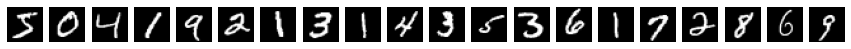

In [4]:
num_samples = 20
samples = range(num_samples)
fig, subplots = plt.subplots(1, num_samples)
fig.set_size_inches(15, 15)

for i, s in enumerate(subplots.flatten()):
    s.imshow(np.reshape(x_train[i, :], [28, 28]), cmap='gray')
    s.axis('off')

Next, we prepare $X$ and $y$ variables

In [5]:
X = x_train[:4000]
y = y_train[:4000]

print(X.shape)
print(y.shape)

(4000, 784)
(4000, 10)


To train the model we will (obviously) use gradient descent. Inside the loop we need a method to compute the gradients. Let's start with implementing it, together with some helper functions.

In [0]:
# We will store the weights in a D x c matrix, where D is the number of features, and c is the number of classes
#weights = (...) # TODO: Fill in, be sure to have the right shape!
weights = np.zeros([X.shape[1], 10])


def softmax(z):
    z_exp = np.exp(z)
    denom = z_exp.sum(axis=1)
    # it's np.diag(1/denom), z_exp) but faster
    return (1. / denom * z_exp.T).T
    return np.dot(np.diag(1/denom), z_exp)

def predict(weights, X):
    ps = softmax(np.dot(X, weights))
    return np.argmax(ps, axis=1)

def compute_loss_and_gradients(weights, X, y, l2_reg):
    sm = softmax(np.dot(X, weights))
    ps = (sm * y).sum(axis=1)
    penalty = l2_reg * (weights ** 2).sum()
    loss = -sum(np.log(ps)) + penalty

    der = sm - 1
    selected_der = y * der
    grad = X.T.dot(selected_der) + 2. * l2_reg * weights
    
    return loss, grad

We are now in position to complete the training pipeline.

If you have problems with convergence, be sure to check the gradients numerically.

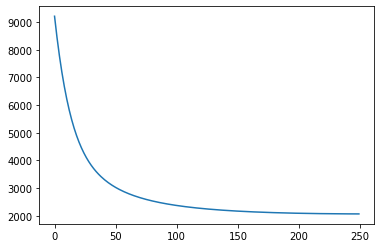

In [7]:
l2_reg = 0.5
n_epochs = 250
lr = 0.000025

losses = []
for i in range(n_epochs):
    loss, grad = compute_loss_and_gradients(weights, X, y, l2_reg)
    losses.append(loss)
    
    weights -= lr * grad

plt.plot(losses)

Now compute your accuracy on the training and test sets.

In [8]:
def accuracy(y, X, weights=weights):
  return sum(predict(weights, X) == y.argmax(axis=1)) / y.shape[0]

print("Train accuracy: {}\n test accuracy: {}".format(
    accuracy(y, X),
    accuracy(y_test, x_test),
  )
)

Train accuracy: 0.865
 test accuracy: 0.8428


We can also visualize the weights learned by our algorithm. Try to anticipate the result before executing the cell below.

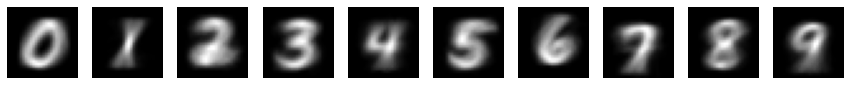

In [9]:
fig, subplots = plt.subplots(1, 10)
fig.set_size_inches(15, 15)

for i, s in enumerate(subplots.flatten()):
    s.imshow(np.reshape(np.array(weights[:, i]), [28, 28]), cmap='gray')
    s.axis('off')


Note that we only used a small portion of the data to develop the model. Now, implement the training on full data. Also, validate your model properly and find a good value for `l2_reg` hyperparameter. Try to experiment with `batch_size`.

In [0]:
import random

def train(xs, ys, l_rate, epochs, batch_size, l2_reg):
  n, m = xs.shape
  ws = np.zeros([m, 10])
  losses = []
  for _ in range(epochs):
    r_sample = np.random.choice(n, batch_size, replace=False)
    batch_xs = xs[r_sample, :]
    batch_ys = ys[r_sample, :]
    loss, grad = compute_loss_and_gradients(ws, batch_xs, batch_ys, l2_reg)
    losses.append(loss)
    ws -= l_rate * grad
  return ws, losses


In [11]:
def cv(xs, ys, k=5, shuffle=True):
  n, m = xs.shape
  s_size = n // k
  n = s_size * k
  inds = list(range(0, n))
  random.shuffle(inds)
  inds_family = [
    [inds[i * s_size + j] for j in range(0, s_size)]
    for i in range(0, k)
  ]
  partitions = [
    ([ind for ind in inds if ind not in v_ind], v_ind)
    for v_ind in inds_family
  ]
  return [
    ((xs[train_set, :], ys[train_set, :]),
     (xs[valid_set, :], ys[valid_set, :]),
     ) 
    for train_set, valid_set in partitions
  ]


def search_best_l2r(xs, ys, l2rs, l_rate, epochs, batch_size):
  res = []
  data = cv(xs, ys, 5)
  for l2r in l2rs:
    accs = []
    for (x_tr, y_tr), (x_tst, y_tst) in data:
      ws, _ = train(x_tr, y_tr, l_rate, epochs, batch_size, l2r)
      accs.append(accuracy(y_tst, x_tst, ws))
    res.append((l2r, np.mean(accs)))
  return res


l2rs = np.linspace(0, 1, 11)

search_best_l2r(x_train, y_train, l2rs, 0.0000005, 60, 4000)


[(0.0, 0.67415),
 (0.1, 0.6786),
 (0.2, 0.6759333333333333),
 (0.30000000000000004, 0.6783),
 (0.4, 0.6735333333333333),
 (0.5, 0.6761666666666667),
 (0.6000000000000001, 0.6810833333333333),
 (0.7000000000000001, 0.6795333333333333),
 (0.8, 0.6811666666666667),
 (0.9, 0.6755333333333333),
 (1.0, 0.6751666666666666)]

Train accuracy: 0.8371333333333333
 test accuracy: 0.8466


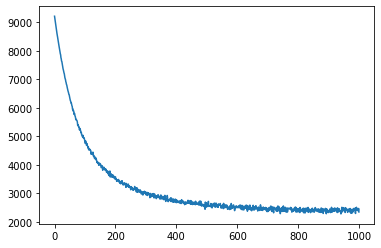

In [12]:
# use lambda to riedge regression chosen with cross validation
ws, losses = train(x_train, y_train, 0.000005, 1000, 4000, 0.8)

plt.plot(losses)

print("Train accuracy: {}\n test accuracy: {}".format(
    accuracy(y_train, x_train, ws),
    accuracy(y_test, x_test, ws),
  )
)

Train accuracy: 0.6203166666666666
 test accuracy: 0.6374
(30.209836049622677, 24.887877528055892, 68.54647294091751)
(26.010420398769053, 21.54230383353586, 29.706590749326395)
(33.47618980351851, 27.509237331315212, 51.813565022661166)
(35.244732386871206, 28.902537410162616, 52.962110984422964)
(34.268043822367346, 27.815635561370556, 41.43604161941498)
(35.95590367897958, 29.556636652832367, 40.56717542867443)
(30.943301988813186, 25.42547258246394, 53.22570195918802)
(33.412680057200284, 26.840048212348762, 40.53469393680164)
(35.674618063629154, 29.58278492684244, 57.911244939520785)
(35.39664272602539, 28.74253361236826, 46.342213664777375)


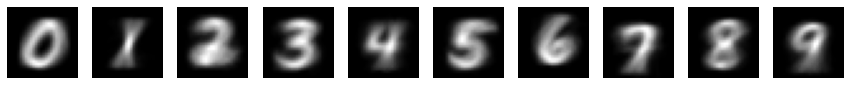

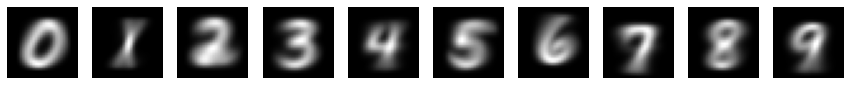

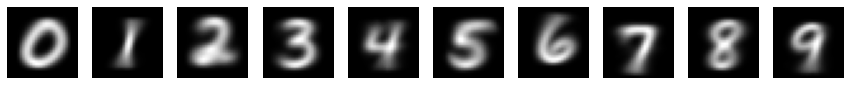

In [49]:
# Subset with 0.5 training vs whole set (batch) training with lambda=0.8

fig, subplots = plt.subplots(1, 10)
fig.set_size_inches(15, 15)

for i, s in enumerate(subplots.flatten()):
    s.imshow(np.reshape(np.array(weights[:, i]), [28, 28]), cmap='gray')
    s.axis('off')


fig, subplots = plt.subplots(1, 10)
fig.set_size_inches(15, 15)
for i, s in enumerate(subplots.flatten()):
    s.imshow(np.reshape(np.array(ws[:, i]), [28, 28]), cmap='gray')
    s.axis('off')



# And how would simple mean look like
fig, subplots = plt.subplots(1, 10)
fig.set_size_inches(15, 15)
means = []
for i, s in enumerate(subplots.flatten()):
    m = x_test[y_test[:, i] == 1., :].mean(axis=0)
    means.append(m)
    s.imshow(np.reshape(m, [28, 28]), cmap='gray')
    s.axis('off')

means = np.array(means).T

print("Train accuracy: {}\n test accuracy: {}".format(
    accuracy(y_train, x_train, means),
    accuracy(y_test, x_test, means),
  )
)


for ww in zip((weights ** 2).sum(axis=0), (ws ** 2).sum(axis=0), (means ** 2).sum(axis=0)):
  print(ww)

(203, 784)
6 4
2 9
8 5
2 3
2 8
3 5
8 9
1 3
2 4
1 3
(165, 784)
2 3
8 9
8 9
8 7
5 9
9 7
5 0
3 5
6 2
9 4


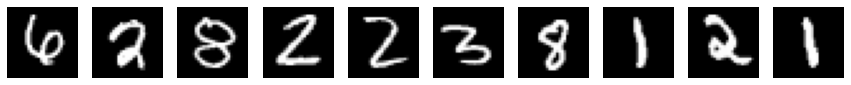

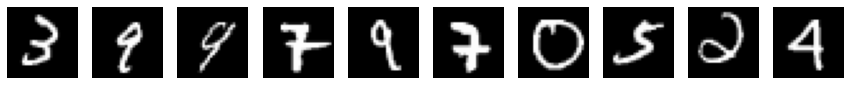

In [47]:
failed_weights = predict(weights, x_test) != y_test.argmax(axis=1)
failed_ws = predict(ws, x_test) != y_test.argmax(axis=1)

# weights failed but ws did well
fig, subplots = plt.subplots(1, 10)
fig.set_size_inches(15, 15)
samples = x_test[(failed_ws ^ failed_weights) & (predict(ws, x_test) == y_test.argmax(axis=1)), :]
print(samples.shape)
for i, s in enumerate(subplots.flatten()):
    s.imshow(np.reshape(np.array(samples[i, :]), [28, 28]), cmap='gray')
    s.axis('off')

for cw, cwg in zip(predict(ws, samples[:10]), predict(weights, samples[:10])):
  print(cw, cwg)


# ws failed but weights did well
fig, subplots = plt.subplots(1, 10)
fig.set_size_inches(15, 15)
samples = x_test[(failed_ws ^ failed_weights) & (predict(weights, x_test) == y_test.argmax(axis=1)), :]
print(samples.shape)
for i, s in enumerate(subplots.flatten()):
    s.imshow(np.reshape(np.array(samples[i, :]), [28, 28]), cmap='gray')
    s.axis('off')

for cw, cwg in zip(predict(ws, samples[:10]), predict(weights, samples[:10])):
  print(cw, cwg)
